In [1]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import sys

In [2]:
from parameters import *
#from variables import *
from initial import *
from advectionx import*
from advectiony import*
from advectionz import*
from dispersionx import *
from dispersiony import *
from dispersionz import *
from degree_conversion import *
from settling import *
from landed import *
from utils import inside_chimney
from matplotlib.ticker import FormatStrFormatter

In [3]:
lon_range = 0.01
lat_range = 0.01
height_limit = 1000

lon1 = start_lon - lon_range
lon2 = start_lon + lon_range
lat1 = start_lat - lat_range
lat2 = start_lat + lat_range

(5000, 3)
(4956, 3)
(4956,)


Text(0.5, 0.92, 'Particle Trajectory')

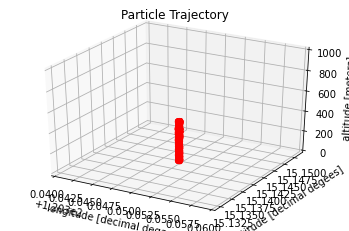

In [4]:
Rold = initial(sigma_lat,sigma_lon)
_, _, inside = inside_chimney(Rold)
print(Rold.shape)
Rold = Rold[inside]
print(Rold.shape)

num_particles = len(Rold)
#particle #,  location of paritcles
Rnew = np.zeros((num_particles,3)) #lat,lon,alt
#Rold = np.zeros((num_particles,3)) #lat,lon,alt
R_step1 = np.zeros((num_particles,3)) #lat,lon,alt
R_step2 = np.zeros((num_particles,3)) #lat,lon,alt
R_step3 = np.zeros((num_particles,3)) #lat,lon,alt
R_step4 = np.zeros((num_particles,3)) #lat,lon,alt
Active = np.ones((num_particles)) #lat,lon,alt
print(Active.shape)


fig = plt.figure(1,facecolor = 'white')
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('longitude [decimal degees]')
ax.set_ylabel('latitude [decimal degees]')
ax.set_zlabel('altitude [meters]')
ax.set_zlim(0,height_limit)
ax.set_ylim(lat1,lat2)
ax.set_xlim(lon1,lon2)
ax.scatter(Rold[:,2],Rold[:,1],Rold[:,0],c='r',s=10)
ax.set_title('Particle Trajectory')

In [5]:
j=3
ts = time.time()
for t in range(1,time_steps):
    
    if t%10 == 0:
        te = time.time()-ts
        print("now at time step: {}({} hours), wall time elapsed: {:6.2f} secs.".format(t, t/time_steps*hours, te))
    
    t_index = int(float(t)/float(time_steps)*20.)
    t_time_1 = float(t)/float(time_steps)*20.
    t_time_2 = (float(t)+0.5)/float(time_steps)*20.
    t_time_3 = (float(t)+0.5)/float(time_steps)*20.
    t_time_4 = (float(t)+1.0)/float(time_steps)*20.    
    
    dx_lat, dx_lon = degree_to_dx(Rold)
    
    #RUNGA KUTTA 
    R_step1[:,:] = 0.0
    R_step2[:,:] = 0.0
    R_step3[:,:] = 0.0
    R_step4[:,:] = 0.0
    #dispersion
    dispz_temp = dispersionz(Active) * dt
    dispy_temp = dispersiony(Active) * dt / dx_lat
    dispx_temp = dispersionx(Active) * dt / dx_lon
    R_step1[:,0] += dispz_temp
    R_step2[:,0] += dispz_temp
    R_step3[:,0] += dispz_temp
    R_step4[:,0] += dispz_temp
    R_step1[:,1] += dispy_temp
    R_step2[:,1] += dispy_temp
    R_step3[:,1] += dispy_temp
    R_step4[:,1] += dispy_temp
    R_step1[:,2] += dispx_temp
    R_step2[:,2] += dispx_temp
    R_step3[:,2] += dispx_temp
    R_step4[:,2] += dispx_temp
    
    #settling
    #R_step1[:,0] -= settling(D,Active) * dt
    #R_step2[:,0] -= settling(D,Active) * dt
    #R_step3[:,0] -= settling(D,Active) * dt
    #R_step4[:,0] -= settling(D,Active) * dt
    
    R_step1[:,0] += advectionz(Rold,Active,t_index,t_time_1) * dt
    R_step1[:,1] += advectiony(Rold,Active,t_index,t_time_1) * dt / dx_lat
    R_step1[:,2] += advectionx(Rold,Active,t_index,t_time_1) * dt / dx_lon
    R_step2[:,0] += advectionz(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt
    R_step2[:,1] += advectiony(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt / dx_lat
    R_step2[:,2] += advectionx(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt / dx_lon
    R_step3[:,0] += advectionz(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt
    R_step3[:,1] += advectiony(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt / dx_lat
    R_step3[:,2] += advectionx(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt / dx_lon
    R_step4[:,0] += advectionz(Rold+R_step3,Active,t_index,t_time_4) * dt
    R_step4[:,1] += advectiony(Rold+R_step3,Active,t_index,t_time_4) * dt / dx_lat
    R_step4[:,2] += advectionx(Rold+R_step3,Active,t_index,t_time_4) * dt / dx_lon

    Rnew =  Rold + R_step1/6.0 + R_step2/3.0 + R_step3/3.0 + R_step4/6.0  
    xyin, zin, _ = inside_chimney(Rold)
    xyin_new, zin_new, both_in_new = inside_chimney(Rnew)
    print(f"ratio of particles inside chimney: {np.sum((xyin&zin))/len(xyin)}")
    print(f"sum of negative or zero heights: {np.sum(Rold[:, 0]<=0)}")
    # reset the xy coordinates (lat, lon) if the particle wants to penetrate the chimney
    cond = (xyin & zin & ~xyin_new & zin_new)
    Rnew[:, 0] = np.where(cond, Rold[:, 0], Rnew[:, 0])
    Rnew[:, 1] = np.where(cond, Rold[:, 1], Rnew[:, 1])
    Rnew[:, 2] = np.where(cond, Rold[:, 2], Rnew[:, 2])
    
    Rnew[:, 0] = np.where(Rnew[:,0] < 0, 0, Rnew[:, 0])
    #Active, Rnew[:,0] = landed(Rnew[:,0],Active)
    
    if t%(time_steps/50)==0:
        ax.scatter(Rnew[:,2],Rnew[:,1],Rnew[:,0],c='k',s=1,alpha=float(t)/float(time_steps-1)*0.5)
        plt.figure(2,facecolor='white')
        x, y = m(Rnew[:,2],Rnew[:,1])
        m.scatter(x,y,s=1,marker='o',color='k',alpha=float(t)/float(time_steps-1)*0.5,zorder=10)
        print(str(int(100.*float(t)/float(time_steps-1))) + '% done')
    if t%(time_steps//100)==0:
        plt.close()
        #plt.figure(j)
        fig = plt.figure(j+10,facecolor = 'white')
        axx = fig.add_subplot(111, projection='3d')
        axx.set_xlabel('lon')
        axx.set_ylabel('lat')
        axx.set_zlabel('altitude [m]')
        axx.set_zlim(0,height_limit)
        axx.set_ylim(lat1,lat2)
        axx.set_xlim(lon1,lon2)
        axx.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        axx.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        Rnew_in = Rnew[both_in_new]
        Rnew_out = Rnew[~both_in_new]
        axx.scatter(Rnew_in[:,2],Rnew_in[:,1],Rnew_in[:,0],c='r',s=1)
        axx.scatter(Rnew_out[:,2],Rnew_out[:,1],Rnew_out[:,0],c='r',s=10)
        axx.set_title('Plume of a chimney')
        axx.view_init(15, 50)
        plt.savefig(f'test_{t}.png')
        axx.view_init(0, 90)
        plt.savefig(f'90test_{t}.png')
        plt.close()
        j+=1
    fig
        
    Rold = Rnew

ratio of particles inside chimney: 1.0
sum of negative or zero heights: 0
ratio of particles inside chimney: 0.9915254237288136
sum of negative or zero heights: 34
ratio of particles inside chimney: 0.9882970137207425
sum of negative or zero heights: 59
ratio of particles inside chimney: 0.9850686037126715
sum of negative or zero heights: 57
ratio of particles inside chimney: 0.9830508474576272
sum of negative or zero heights: 58
ratio of particles inside chimney: 0.983454398708636
sum of negative or zero heights: 72
ratio of particles inside chimney: 0.9812348668280871
sum of negative or zero heights: 71
ratio of particles inside chimney: 0.9782082324455206
sum of negative or zero heights: 55
ratio of particles inside chimney: 0.9747780468119451
sum of negative or zero heights: 66
now at time step: 10(0.008298755186721992 hours), wall time elapsed:   1.97 secs.
ratio of particles inside chimney: 0.9729620661824052
sum of negative or zero heights: 63
ratio of particles inside chimney: 

ratio of particles inside chimney: 0.880548829701372
sum of negative or zero heights: 80
ratio of particles inside chimney: 0.8795399515738499
sum of negative or zero heights: 73
ratio of particles inside chimney: 0.8781275221953188
sum of negative or zero heights: 75
now at time step: 90(0.07468879668049792 hours), wall time elapsed:  25.89 secs.
ratio of particles inside chimney: 0.8777239709443099
sum of negative or zero heights: 66
ratio of particles inside chimney: 0.8761097659402745
sum of negative or zero heights: 66
ratio of particles inside chimney: 0.8755044390637611
sum of negative or zero heights: 67
ratio of particles inside chimney: 0.8746973365617433
sum of negative or zero heights: 69
ratio of particles inside chimney: 0.8728813559322034
sum of negative or zero heights: 67
ratio of particles inside chimney: 0.8722760290556901
sum of negative or zero heights: 71
ratio of particles inside chimney: 0.8700564971751412
sum of negative or zero heights: 69
ratio of particles i

ratio of particles inside chimney: 0.8010492332526231
sum of negative or zero heights: 70
ratio of particles inside chimney: 0.8000403551251009
sum of negative or zero heights: 82
ratio of particles inside chimney: 0.8004439063761097
sum of negative or zero heights: 76
ratio of particles inside chimney: 0.7998385794995965
sum of negative or zero heights: 90
ratio of particles inside chimney: 0.7980225988700564
sum of negative or zero heights: 86
ratio of particles inside chimney: 0.7974172719935432
sum of negative or zero heights: 73
ratio of particles inside chimney: 0.7974172719935432
sum of negative or zero heights: 79
ratio of particles inside chimney: 0.7958030669895076
sum of negative or zero heights: 99
ratio of particles inside chimney: 0.7958030669895076
sum of negative or zero heights: 90
now at time step: 180(0.14937759336099585 hours), wall time elapsed:  59.36 secs.
ratio of particles inside chimney: 0.7956012913640033
sum of negative or zero heights: 80
ratio of particles

Text(0.5, 0.92, 'Particle Trajectory')

<Figure size 432x288 with 0 Axes>

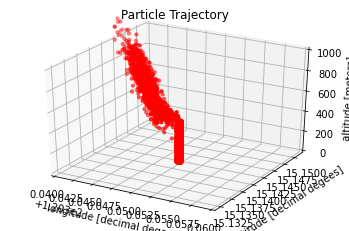

In [6]:
for i in range(0,num_particles):
    if Active[i] == 0:
        ax.scatter(Rnew[i,2],Rnew[i,1],Rnew[i,0],c='g',s=10)
        plt.figure(2,facecolor='white')
    else:
        ax.scatter(Rnew[i,2],Rnew[i,1],Rnew[i,0],c='b',s=10)
        plt.figure(2,facecolor='white')
        
fig1 = plt.figure(1,facecolor='white')
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('longitude [decimal degees]')
ax.set_ylabel('latitude [decimal degees]')
ax.set_zlabel('altitude [meters]')
ax.set_zlim(0,height_limit)
ax.set_ylim(lat1,lat2)
ax.set_xlim(lon1,lon2)
#ax.view_init(15, 50)
ax.scatter(Rnew[:,2],Rnew[:,1],Rnew[:,0],c='r',s=10)
ax.set_title('Particle Trajectory')